# Simulation of RCT EMS v3

Three scenarios: 

1. weekday
2. weekend
3. weekend with disaster

Three dispatch policies for ambulance selection: 
1. fastest ambulance 
2. least coverage disruption
3. optimal by weighting travel time and coverage

Nine total simulations, each compared. 

# Case count distributions

Each simulation has 100 cases regardless of how the scenarios will play out. This should mean that the disaster scenario will finish 100 cases in less time because there is a disaster time slot where many cases occur. We want to see if this is the case by comparing the disaster scenarios against the weekday and weekend scenarios. The dispatch policy might affect the distributions, but probably not be too much. 

# Cases reached before r1: 10 minutes

Since previous RCT studies looked at using the US EMS Act as the standard, we want to know how many cases are reached before the 10 minute requirement. If this is not reached, it's still helpful to know if the case was reached before the 14 minute secondary coverage requirement. 

Since Pons stated 8 minutes is the time when statistics actually found significant difference in case effectiveness, it may be useful to count the cases reached before 8 minutes. 

# Double coverage 

Plot the double coverage of the simulated RCTs over time. Here, the dispatch policy is important, and the specific scenarios may or may not make a difference. We expect to see best travel to do the worst, but weighted should have similar shape with best travel time despite being a little better. 

<hr/>

In [1]:
# Use matplotlib to graph and not bokeh (learn curve). 
# No command line magic, only analysis. 

# %matplotlib notebook
import matplotlib.pyplot as plt
# plt.rcParams.update({'figure.max_open_warning': 0})

import pandas
import scipy.stats as stats
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np
from numpy import median, mean

from datetime import datetime, timedelta

from functools import reduce
from collections import Counter
import yaml 

In [2]:
plt.rcParams['figure.figsize'] = 3,2

plt.rcParams['figure.dpi'] = 200 # 200
# plt.rcParams['figure.dpi'] = 110 # 200

plt.rcParams['figure.figsize'], plt.rcParams['figure.dpi']

([3.0, 2.0], 200.0)

In [3]:
def save(name):
    directory = './figures/'
    plt.savefig(directory + name, pad_inches=0, bbox_inches='tight')

<hr/>

#       READ DATA INTO THE NOTEBOOK:

In [4]:
csvs = [ # Every simulation produces these files.
    "chosen_ambulances.csv",
    "chosen_bases.csv",
    "chosen_hospitals.csv",
    "metrics.csv",
    "processed_cases.csv",
]


scenarios = [ # Three scenarios, two from the RCT, one additional contributed scenario 
    "weekday",
    "weekend",
    "disaster", # Note that the base scenario is weekend with a disaster intejected inside
]

policies = [ # Three ambulance dispatch policies were tested 
    "best-travel",
    "best-coverage",
    "weighted-dispatch",
]

result_directories = [ # This notebook is assumed to be in the home project repository directory. 
    "tj-{scenario}-{policy}/".format( scenario=scenario, policy=policy) \
    for scenario in scenarios for policy in policies
]

result_directories += [
    '/scaling-weeks-best-travel/', 
    '/scaling-weeks-best-coverage/', 
    '/depleting-until-zero/',
]



data_files = [
    directory + csv \
    for directory in result_directories for csv in csvs
]

# Test the filenames and counts formed correctly

# for r in result_directories: print(r) 
# print(len(result_directories))

# for f in data_files: print(f) 
# print(len(data_files))


def read_folder(data_files):
    
    """
    For each folder (simulation), read in their csv results
    
    data_files: a list of strs pointing to each csv file in the results
    returns: a dict(k: scenario, policy, data_name, v: pandas representation of the csv)
    """
    
    assert isinstance(data_files, list) 
    for data in data_files: assert isinstance(data, str)
    return {data: pandas.read_csv("../results/" + data) for data in data_files}


dataset = read_folder(data_files) # Now the source of truth for data

# Test the data set 
# for k in dataset.keys(): print(k); print(type(dataset[k]))
# print(len(dataset))

# EMERGENCY CASE DISTRIBUTIONS DRAWN OVER THE ZONES

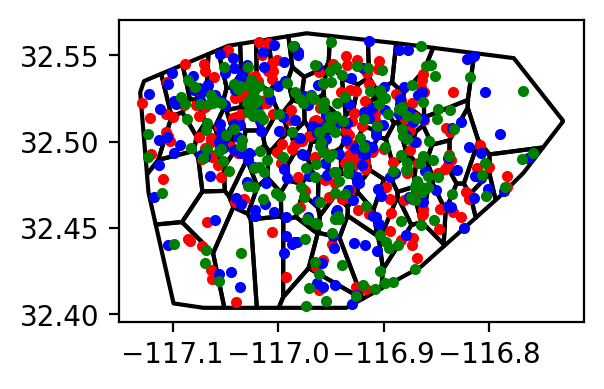

Take out the slicing from line 26 if want *every* case plotted.


In [5]:
title = "Location of Generated Emergencies"
# plt.figure(title)
# plt.title(title)
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")


# Read the polygons and draw the matplotlibs. Return lat longs, as longs lats (xs ys)
xs = yaml.full_load(open('../../longitudes.yaml'))
ys = yaml.full_load(open('../../latitudes.yaml'))



for i in range(len(xs)):
    plt.plot(xs[i] + [xs[i][0]], ys[i] + [ys[i][0]],  '-', color='black')


# processed cases for each simulation 
cases = {k:v for k,v in dataset.items() if "processed_cases" in k}

gen_cases = {filename: cases[filename] for filename in cases \
             if "best-travel" in filename and "tj" in filename}

colors = ['green', 'blue', 'red']

num_cases = 200

for case_name in gen_cases:
    label = case_name.split('/')[0].replace('-', ' ')
    plt.plot(cases[case_name].longitude[0:num_cases], cases[case_name].latitude[0:num_cases], '.', 
             color=colors.pop(), label=label)

# plt.legend()
save('case-generation.png')
plt.show()

print("Take out the slicing from line 26 if want *every* case plotted.")

In [6]:
# processed cases for each simulation 
cases = {k:v for k,v in dataset.items() if "processed_cases" in k}

gen_cases = {filename: cases[filename] for filename in cases if "best-travel" in filename}

for name in gen_cases:
    continue # UNCOMMENT TO DISPLAY SEPARATE GRAPHS
    plt.figure(name)
    plt.title(name)
    for i in range(len(xs)):
        plt.plot(xs[i] + [xs[i][0]], ys[i] + [ys[i][0]], )
    plt.plot(gen_cases[name].longitude, gen_cases[name].latitude, '.', color='black')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# CASE COUNT DISTRIBUTIONS

In [7]:
# Define the functions necessary to accumulate each set of case datetimes 
# in order to bin them into histographic distributions.

# Draw the histogram for each scenario, before drawing a histogram for all scenarios

# processed cases for each simulation 
cases = {k:v for k,v in dataset.items() if "processed_cases" in k}


    
def plot_histogram_basic(processed_cases, name):
    """
    For each list of processed cases, draw the histogram distribution of cases per hour.
    """
    assert isinstance(processed_cases, pandas.core.frame.DataFrame)
    assert isinstance(name, str)
    
    # Logic towards the histogram 
    dates = [datetime.strptime(arr[1], '%Y-%m-%d %H:%M:%S.%f').replace(
        minute=0, second=0, microsecond=0) for arr in processed_cases.values]
    
    first = dates[0]
    deltas = [(date-first).total_seconds()/3600 for date in dates]
    
    c = Counter(deltas)
    sum(c.values())

    l = list(deltas)

    # Logic towards the smooth histogram
    smooth_xs = np.linspace(int(min(c.keys())), int(max(c.keys())), len(c.keys()))
    spl = make_interp_spline(list(c.keys()), list(c.values()), k=3)
    smooth_ys = spl(smooth_xs)
    
    
    # Draw the blocky histogram
    figure_title = "Case count per hour: " + name + ""
    plt.figure(figure_title)
    plt.title(figure_title)
    ys, xs, patches = plt.hist(deltas, bins=int((max(deltas)+1)/1), histtype='step')
    plt.xlabel("Number of hours since starting"); plt.ylabel('Number of cases')

    # Draw the smoothed histogram
    plt.hist(deltas, bins=int((max(deltas)+1)), histtype='step', color='black')
    plt.xlabel("Number of hours since starting"); plt.ylabel('Number of cases')
    # plt.ylim(0,10)
    plt.plot(smooth_xs, smooth_ys, '-', color='red')
    
    plt.show()
    


# Draw each processed cases' case count. COMMENT OUT WHEN NOT NEEDED.
for name, processed_cases in cases.items():
#     plot_histogram_basic(processed_cases, name) 
    pass
    
    
    
def histogram_collapsed(processed_cases, name):
    """
    For each list of processed cases, draw the histogram distribution of cases per hour.
    """
    assert isinstance(processed_cases, pandas.core.frame.DataFrame)
    assert isinstance(name, str)
    
#     print(name)
    
    # Logic towards the histogram 
    dates = [datetime.strptime(arr[1], '%Y-%m-%d %H:%M:%S.%f').replace(
        minute=0, second=0, microsecond=0) for arr in processed_cases.values]
    
    first = dates[0]
    deltas = [(date-first).total_seconds()/3600 for date in dates]
    
    c = Counter(deltas)
    sum(c.values())

    l = list(deltas)

    # Logic towards the smooth histogram
    smooth_xs = np.linspace(int(min(c.keys())), int(max(c.keys())), len(c.keys()))
    spl = make_interp_spline(list(c.keys()), list(c.values()), k=3)
    smooth_ys = spl(smooth_xs)
    
    
    # Draw the blocky histogram
    figure_title = "Cases per hour, all"
#     plt.figure(figure_title)
#     plt.title(figure_title)
#     ys, xs, patches = plt.hist(deltas, bins=int((max(deltas)+1)/1), histtype='step')
    plt.xlabel("Number of hours since starting"); plt.ylabel('Number of cases')
    plt.xlim(0,24)

    # Draw the smoothed histogram
    plt.hist(deltas, bins=int((max(deltas)+1)), histtype='step')
    plt.xlabel("Number of hours since starting"); plt.ylabel('Number of cases')
    plt.ylim(0,38)
    label = name.split('/')[0].replace('-', ' ')
#     print(label)
    plt.plot(smooth_xs, smooth_ys, '-', label=label)




In [8]:
# individual_coverage = "Individual coverage"
# plt.figure(individual_coverage)
# plt.title(individual_coverage)
# for name, processed_cases in cases.items():
#     if "weekday-best-travel" in name:
# #         print(name)
# #         histogram_collapsed(processed_cases, name) 
#         pass
# plt.legend()    
# plt.show()

In [9]:
# plt.figure(individual_coverage)
# plt.title(individual_coverage)
# for name, processed_cases in cases.items():
#     if "weekend-best-travel" in name:
# #         print(name)
#         histogram_collapsed(processed_cases, name) 
# plt.legend()
# plt.show()

In [10]:
# plt.figure(individual_coverage)
# plt.title(individual_coverage)
# for name, processed_cases in cases.items():
#     if "disaster-best-travel" in name:
# #         print(name)
#         histogram_collapsed(processed_cases, name) 
# plt.legend()
# plt.show()

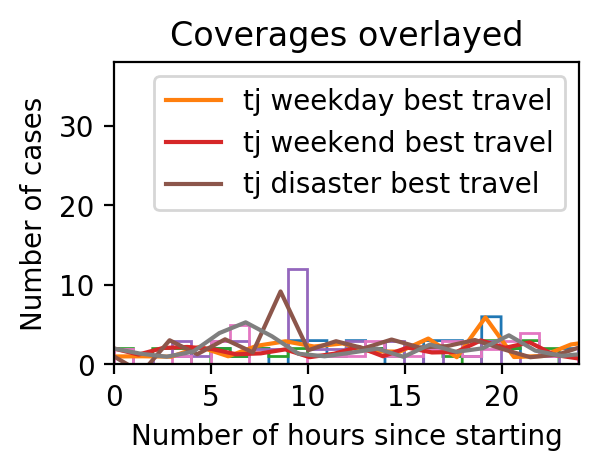

So this one is interesting but we're showing that different scenarios results in different lengths of time required to finish solving that many cases. 


In [11]:
all_coverages='Coverages overlayed'
plt.figure(all_coverages)
plt.title(all_coverages)
for name, processed_cases in cases.items():
    if "best-travel" in name:
        histogram_collapsed(processed_cases, name) 
        
plt.legend()
save('cases-per-hour')
plt.show()

caption = "So this one is interesting but we're showing that different scenarios results in different \
lengths of time required to finish solving that many cases. "

print(caption)

Comments:
1. Seems like the case distribution for each hour are the same. 
2. This is pretty expected, since the density of cases is not extremely high, we don't hit the case delay scenario too often (really, only in the disaster scenario). 
3. Because of that, the major differences here are between each scenario, which makes sense. 

# A plot for each scenario for total case duration or average case duration 


In [12]:
cases = {k:v for k,v in dataset.items() if "processed_cases" in k}

# Grab the indices which store the durations
indices = []
for name, caseset in cases.items(): 
    keys = caseset.keys()
    for index in range(len(keys)):
        if 'duration' in keys[index]: 
            print(index, keys[index])
            indices += [index]
        
    break

# For each case, determine the total duration. List of casesets, which contain list of cases. Use transformations. 

# [[[case[index] for index in indices] for case in caseset] for caseset in cases]

cleaned_cases = {name: [{column_name: float(mean([pandas.to_timedelta(d).total_seconds()/60 for d in data]))} for column_name, data in caseset.items() if "duration" in column_name] for name, caseset in cases.items()}


with open('mean_times.yaml', 'w') as output:
    output.write(yaml.dump(cleaned_cases))

total_average_durations = {name: sum([v for times_d in times for k, v in times_d.items()]) for name, times in cleaned_cases.items()}
    
with open('mean_times.yaml', 'a') as output:
    output.write(yaml.dump(total_average_durations))


7 TO_INCIDENT_duration
8 AT_INCIDENT_duration
9 TO_HOSPITAL_duration
10 AT_HOSPITAL_duration
11 TO_BASE_duration
12 OTHER_duration


In [13]:
cleaned_cases

{'tj-weekday-best-travel/processed_cases.csv': [{'TO_INCIDENT_duration': 8.782350000000001},
  {'AT_INCIDENT_duration': 7.551033333333333},
  {'TO_HOSPITAL_duration': 16.208433333333335},
  {'AT_HOSPITAL_duration': 7.589716666666667},
  {'TO_BASE_duration': 12.76895},
  {'OTHER_duration': 0.0}],
 'tj-weekday-best-coverage/processed_cases.csv': [{'TO_INCIDENT_duration': 18.2515},
  {'AT_INCIDENT_duration': 7.689016666666666},
  {'TO_HOSPITAL_duration': 16.208433333333335},
  {'AT_HOSPITAL_duration': 7.502866666666667},
  {'TO_BASE_duration': 11.333333333333336},
  {'OTHER_duration': 0.0}],
 'tj-weekday-weighted-dispatch/processed_cases.csv': [{'TO_INCIDENT_duration': 15.712866666666667},
  {'AT_INCIDENT_duration': 7.452716666666666},
  {'TO_HOSPITAL_duration': 16.208433333333335},
  {'AT_HOSPITAL_duration': 7.453049999999999},
  {'TO_BASE_duration': 11.450716666666667},
  {'OTHER_duration': 0.0}],
 'tj-weekend-best-travel/processed_cases.csv': [{'TO_INCIDENT_duration': 9.069833333333332

In [14]:
total_average_durations

{'tj-weekday-best-travel/processed_cases.csv': 52.90048333333334,
 'tj-weekday-best-coverage/processed_cases.csv': 60.985150000000004,
 'tj-weekday-weighted-dispatch/processed_cases.csv': 58.27778333333333,
 'tj-weekend-best-travel/processed_cases.csv': 53.05794999999999,
 'tj-weekend-best-coverage/processed_cases.csv': 60.82055000000001,
 'tj-weekend-weighted-dispatch/processed_cases.csv': 58.45023333333333,
 'tj-disaster-best-travel/processed_cases.csv': 55.45926666666667,
 'tj-disaster-best-coverage/processed_cases.csv': 61.20388333333334,
 'tj-disaster-weighted-dispatch/processed_cases.csv': 58.39205,
 '/scaling-weeks-best-travel/processed_cases.csv': 51.38341666666667,
 '/scaling-weeks-best-coverage/processed_cases.csv': 59.231500000000004,
 '/depleting-until-zero/processed_cases.csv': 53.01672222222222}

## Case durations 

- There is a lot of variance due to the random generation of the at_location durations
- In the disaster scenario, the average case duration with best travel time is almost just as bad as other two dispatch policies on normal days. 


# A plot for average case duration totals 

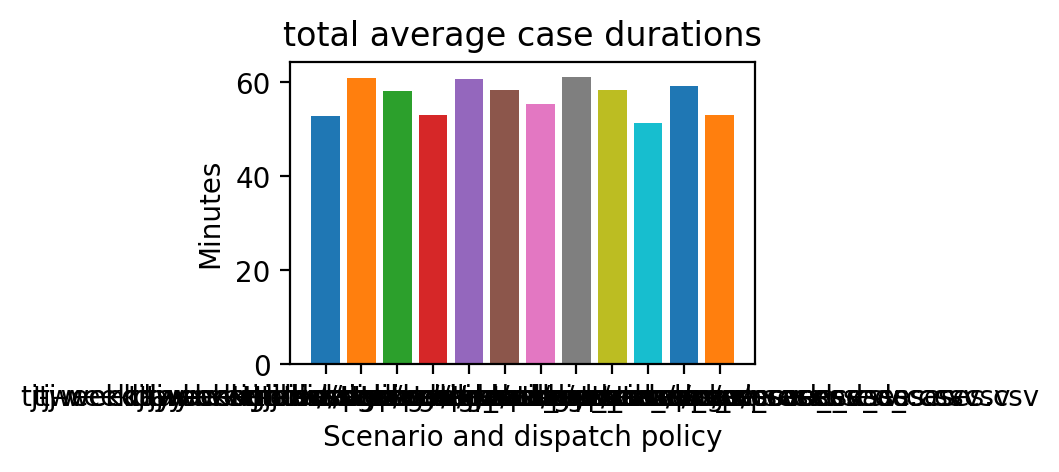

In [15]:
name = "total average case durations"
plt.figure(name); plt.title(name)

plt.xlabel("Scenario and dispatch policy"); plt.ylabel("Minutes")

for name, duration in total_average_durations.items():
    plt.bar(name, duration)

plt.show()


# A plot for average E1 durations only

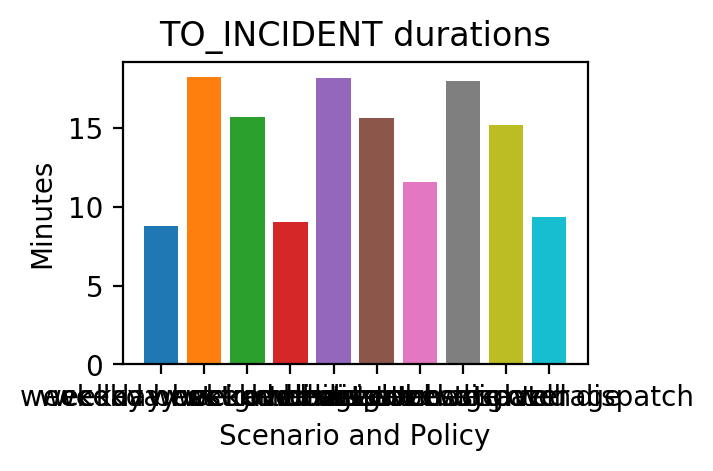

In [16]:
e1s = {}

for name, durations in cleaned_cases.items():
    
    # Name only the scenario and the dispatch policy 
    name = name.split('/')[0].split('-')[1:4]
    name = " ".join(name)
    
    for d in durations:
        for k, v in d.items():
            if 'TO_INCIDENT' in k:
                e1s[name] = v
    
e1s

name = "TO_INCIDENT durations"

plt.figure(name)
plt.title(name)

for k, v in e1s.items():
    plt.bar(k, v, label=k)


# plt.ylim(0,80)
    
plt.xlabel('Scenario and Policy')
plt.ylabel("Minutes")
# plt.legend()

plt.show()


# REACHING EMERGENCY POINTS WITHIN TIME LIMIT

In [17]:
# to incident durations

def plot_travel_times_basic(processed_cases, name):
    
    assert isinstance(processed_cases, pandas.core.frame.DataFrame)
    assert isinstance(name, str)
    
    # Logic for counting cases reached within some time. 
    durations = [pandas.to_timedelta(array[7]) for array in processed_cases.values]
    r1 = timedelta(minutes=10)
    r2 = timedelta(minutes=14)
    
    times = {
    'lt_r1' : list(filter(lambda t: t <  r1, durations)),
    'lt_r2' : list(filter(lambda t: t <  r2 and t >= r1, durations)),
    'beyond': list(filter(lambda t: t >= r2, durations)),
    }

    counts = {k:len(v) for k,v in times.items()}
    
    # Draw the bar graphs

    figure_title = "Travel times for the TO_INCIDENT events:" + name
#     plt.figure(figure_title)
#     plt.title(figure_title)

#     plt.bar(counts.keys(), counts.values())
#     plt.xlabel("Event TO_INCIDENT times separated by travel time")
#     plt.ylabel('Number of cases')
    
#     plt.show()

    print(figure_title)
    print(counts)
#     print('*'*40 + '\n')
    
#     return

# Draw each processed cases' travel times. COMMENT OUT WHEN NOT NEEDED.
for name, processed_cases in cases.items():
#     continue # DON'T NEED UNSEPARATED PRIORITIES
#     plt.figure()
    plot_travel_times_basic(processed_cases, name) 


Travel times for the TO_INCIDENT events:tj-weekday-best-travel/processed_cases.csv
{'lt_r1': 622, 'lt_r2': 283, 'beyond': 95}
Travel times for the TO_INCIDENT events:tj-weekday-best-coverage/processed_cases.csv
{'lt_r1': 119, 'lt_r2': 158, 'beyond': 723}
Travel times for the TO_INCIDENT events:tj-weekday-weighted-dispatch/processed_cases.csv
{'lt_r1': 239, 'lt_r2': 207, 'beyond': 554}
Travel times for the TO_INCIDENT events:tj-weekend-best-travel/processed_cases.csv
{'lt_r1': 594, 'lt_r2': 308, 'beyond': 98}
Travel times for the TO_INCIDENT events:tj-weekend-best-coverage/processed_cases.csv
{'lt_r1': 114, 'lt_r2': 164, 'beyond': 722}
Travel times for the TO_INCIDENT events:tj-weekend-weighted-dispatch/processed_cases.csv
{'lt_r1': 241, 'lt_r2': 209, 'beyond': 550}
Travel times for the TO_INCIDENT events:tj-disaster-best-travel/processed_cases.csv
{'lt_r1': 469, 'lt_r2': 269, 'beyond': 262}
Travel times for the TO_INCIDENT events:tj-disaster-best-coverage/processed_cases.csv
{'lt_r1': 

Comments
1. This one is actually really interesting. 
2. Least disruption is terrible in all scenarios and this makes sense because this dispatch policy goes against the whole point of EMS which is to **quickly** reach the patient.
3. In the Weekdays scenario, there was no change between BTT and weighted.
4. In the Weekends scenario, BTT did the best. However, we do not know whether it was **necessary** for this to happen. 
5. In the disaster scenario, weighted did the best. It seems like a few of the r2's became r1, and some other r2's went beyond r2. 
6. None of this paints a complete picture, because we're not only interested in how many cases were filled in r1, but we're also interested in, of these cases, how many **top priority** cases were reached with r1. 

Note: different scenarios produced a different set of cases so at the moment it's mainly just worth comparing within scenarios 

# Event.TO_INCIDENT for Priority 1 only

In [18]:
# Implement the exact same code as above, but filter for the Priority 1 cases. 

def plot_travel_times_priority1(processed_cases, name):
    
    assert isinstance(processed_cases, pandas.core.frame.DataFrame)
    assert isinstance(name, str)
    
    # Logic for counting cases reached within some time. 
    durations = [pandas.to_timedelta(array[7]) for array in processed_cases.values 
                 if array[4] == 1]
    r1 = timedelta(minutes=10)
    r2 = timedelta(minutes=14)
    
    times = {
    'lt_r1' : list(filter(lambda t: t <  r1, durations)),
    'lt_r2' : list(filter(lambda t: t <  r2 and t >= r1, durations)),
    'beyond': list(filter(lambda t: t >= r2, durations)),
    }

    counts = {k:len(v) for k,v in times.items()}
    
    # Draw the bar graphs

    figure_title = "Travel times for the TO_INCIDENT events:" + name
#     plt.figure(figure_title)
#     plt.title(figure_title)

#     plt.bar(counts.keys(), counts.values())
#     plt.xlabel("Event TO_INCIDENT times separated by travel time")
#     plt.ylabel('Number of cases')
    
    plt.show()
    print(figure_title)
    print(counts)
#     print('*'*40 + '\n')
    
#     return

# Draw each processed cases' travel times. COMMENT OUT WHEN NOT NEEDED.
for name, processed_cases in cases.items():
    if "best-coverage" in name: 
        continue
    plot_travel_times_priority1(processed_cases, name) 

Travel times for the TO_INCIDENT events:tj-weekday-best-travel/processed_cases.csv
{'lt_r1': 26, 'lt_r2': 5, 'beyond': 5}
Travel times for the TO_INCIDENT events:tj-weekday-weighted-dispatch/processed_cases.csv
{'lt_r1': 26, 'lt_r2': 6, 'beyond': 4}
Travel times for the TO_INCIDENT events:tj-weekend-best-travel/processed_cases.csv
{'lt_r1': 17, 'lt_r2': 9, 'beyond': 4}
Travel times for the TO_INCIDENT events:tj-weekend-weighted-dispatch/processed_cases.csv
{'lt_r1': 17, 'lt_r2': 10, 'beyond': 3}
Travel times for the TO_INCIDENT events:tj-disaster-best-travel/processed_cases.csv
{'lt_r1': 72, 'lt_r2': 54, 'beyond': 112}
Travel times for the TO_INCIDENT events:tj-disaster-weighted-dispatch/processed_cases.csv
{'lt_r1': 85, 'lt_r2': 55, 'beyond': 98}
Travel times for the TO_INCIDENT events:/scaling-weeks-best-travel/processed_cases.csv
{'lt_r1': 6, 'lt_r2': 6, 'beyond': 0}
Travel times for the TO_INCIDENT events:/depleting-until-zero/processed_cases.csv
{'lt_r1': 4, 'lt_r2': 1, 'beyond': 

# AVERAGE TRAVEL TIME FOR EACH PRIORITY

In [19]:
def average_travel_times_priority(processed_cases, name, priority):
    
    assert isinstance(processed_cases, pandas.core.frame.DataFrame)
    assert isinstance(name, str)
    
    # Logic for counting cases reached within some time. 
    durations = [pandas.to_timedelta(array[7]) for array in processed_cases.values 
                 if array[4] == priority]
    r1 = timedelta(minutes=10)
    r2 = timedelta(minutes=14)
    
    times = {
    'lt_r1' : list(filter(lambda t: t <  r1, durations)),
    'lt_r2' : list(filter(lambda t: t <  r2 and t >= r1, durations)),
    'beyond': list(filter(lambda t: t >= r2, durations)),
    }

    counts = {k:len(v) for k,v in times.items()}
    avg = mean(durations).total_seconds()
    total = sum([t.total_seconds() for t in durations])
    
    print(name, priority)
    print(counts)
    print("Average to_incident duration: ", avg)
    print("Total time in seconds for E1: ", total)


# Draw each processed cases' travel times. COMMENT OUT WHEN NOT NEEDED.
for priority in range(1, 5):
    for name, processed_cases in cases.items():
        if "tj" not in name:
            continue
        if "coverage" in name: 
            continue
        average_travel_times_priority(processed_cases, name, priority) 
        print()
    print("#"*80)

tj-weekday-best-travel/processed_cases.csv 1
{'lt_r1': 26, 'lt_r2': 5, 'beyond': 5}
Average to_incident duration:  518.222222222
Total time in seconds for E1:  18656.0

tj-weekday-weighted-dispatch/processed_cases.csv 1
{'lt_r1': 26, 'lt_r2': 6, 'beyond': 4}
Average to_incident duration:  512.027777777
Total time in seconds for E1:  18433.0

tj-weekend-best-travel/processed_cases.csv 1
{'lt_r1': 17, 'lt_r2': 9, 'beyond': 4}
Average to_incident duration:  566.5
Total time in seconds for E1:  16995.0

tj-weekend-weighted-dispatch/processed_cases.csv 1
{'lt_r1': 17, 'lt_r2': 10, 'beyond': 3}
Average to_incident duration:  561.7
Total time in seconds for E1:  16851.0

tj-disaster-best-travel/processed_cases.csv 1
{'lt_r1': 72, 'lt_r2': 54, 'beyond': 112}
Average to_incident duration:  909.302521008
Total time in seconds for E1:  216414.0

tj-disaster-weighted-dispatch/processed_cases.csv 1
{'lt_r1': 85, 'lt_r2': 55, 'beyond': 98}
Average to_incident duration:  844.44117647
Total time in se

Finally, after using the new formula for weighing the two dispatches, a lot of the priority 4 cases have been sacrificed to improve priorities 1-3. There are definite improvements in Priority 2 and 3 cases, while the Priority 1 cases remained the same. It was hoped that priority 1 would improve as well and maybe that will happen after double coverage is implemented.

# COVERAGE FOR EACH SIMULATION

In [20]:
metrics = {k:v for k,v in dataset.items() if "metrics" in k}

def draw_coverage_basic(metrics, name):

    coverages = [(pandas.to_datetime(arr[0]), float(arr[1]), float(arr[2])) for arr in metrics.values]
    coverages.sort()

    xs = [cov[0] for cov in coverages]
    ys = [cov[1] for cov in coverages]
    ys2 = [cov[2] for cov in coverages]

    first = xs[0]
    xs = [(date-first).total_seconds()/3600 for date in xs]

    # Smoothed the original
    smooth_xs = np.linspace(int(min(xs)), int(max(xs)), len(xs)//4)

    spl = make_interp_spline(xs, ys, k=1)
    smooth_ys = spl(smooth_xs)
    
    spl2 = make_interp_spline(xs, ys2, k=1)
    smooth_ys2 = spl2(smooth_xs)

    name = name.split('/')[0].replace('-', ' ')
    figure_title = "Coverage: " + name
    plt.figure(figure_title)
    plt.title(figure_title)
    plt.xlim(0,24)
    plt.ylim(-1, 100)
#     plt.xlabel("Number of hours since starting"); 
    plt.ylabel('Coverage')

    plt.plot(smooth_xs, smooth_ys, '-', color='blue', label='Primary coverage')
    plt.plot(smooth_xs, smooth_ys2, '-', color='teal', label='Secondary coverage')
    
    plt.legend()
    plt.show()
    

for name, metric in metrics.items(): 
#     draw_coverage_basic(metric, name)
    pass

Comments: 
1. Just based on the primary coverage (double is currently missing), it seems like the BTT finished all the cases the soonest. However, as we saw above with the travel times, it's interesting because less cases were reached within r1 using btt. Again, with the travel times, it's going to be interesting to see whether more high priority cases were reached (or maybe **all of the disaster cases** are high/top priority? Probably requires more thought...) And also the double coverage is going to paint a better picture of what's happening. 

In [21]:
def draw_coverage_overlayed(metrics, name, colors, level, ax = None, xlim_cap=24, ticks=8):

    coverages = [(pandas.to_datetime(arr[0]), float(arr[1]), float(arr[2])) for arr in metrics.values]
    coverages.sort()

    xs = [cov[0] for cov in coverages]
    ys = [cov[1] for cov in coverages]
    ys2 = [cov[2] for cov in coverages]
    
    plt.bar([3,9, 15, 21], [100,100,100,100], width=5.5, color='whitesmoke')
    print("Name is {}".format(name))
    if 'disaster' in name:
        plt.bar([14], [100], width=1, color='pink')

    first = xs[0]
    xs = [(date-first).total_seconds()/3600 for date in xs]

#     print(all([xs[i] <= xs[i+1] for i in range(len(xs)-1)]))

    # Smoothed the original
    smooth_xs = np.linspace(int(min(xs)), int(max(xs)), len(xs)//4)

    spl = make_interp_spline(xs, ys, k=1)
    smooth_ys = spl(smooth_xs)
    
    spl2 = make_interp_spline(xs, ys2, k=1)
    smooth_ys2 = spl2(smooth_xs)


    figure_title = "Coverage: overlayed"
#     plt.figure(figure_title)
#     plt.title(figure_title)
    plt.ylim(-1, 80)
    plt.xlim(0, xlim_cap)
    plt.xticks(range(0, xlim_cap, xlim_cap//ticks))
#     plt.xlabel("Number of hours since starting")
    plt.ylabel('Coverage')
    
    name = name.split('/')[0].replace('-', ' ')
#     plt.plot(xs, ys, 'b.' )

    plot_outputs = []

    color = colors.pop() if colors else None
    if 'primary' in level: 
        plot_outputs.append(plt.plot(smooth_xs, smooth_ys, '-', color=color, label=name + " primary"))
    color = colors.pop() if colors else None
    if 'secondary' in level: 
        plot_outputs.append(plt.plot(smooth_xs, smooth_ys2, '-', color=color, label=name + " secondary"))
    
    
    return plt, smooth_xs, plot_outputs


In [22]:
def plot_overlay(term):
    plt.figure()
    colors = ['blue', 'teal', 'red', 'orange', 'black', 'grey']
    for name, metric in metrics.items(): 
        if term in name: 
            plot_colors = None
            if colors:
                plot_colors = [colors.pop(), colors.pop()]
            print(name, plot_colors)
            draw_coverage_overlayed(metric, name, plot_colors, ['primary', 'secondary'], ax=plt)
    print("Note: the colors are [secondary color, primary color].")
    plt.legend()
    plt.show()

In [23]:
# plot_overlay("weekday")

In [24]:
# plot_overlay("weekend")

In [25]:
# plot_overlay("disaster")

In [26]:
# plot_overlay("best-travel")

In [27]:
# plot_overlay("coverage")

In [28]:
# plot_overlay("weighted-dispatch")

In [29]:
# plot_overlay('')

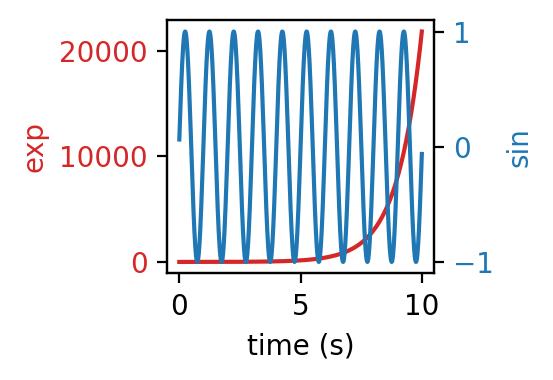

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Plot the travel times duration points with the coverage already implemented above. 

## Specific plots:
- Weekend: Comparing the primary coverage vs secondary coverage for each policy
- Disaster: Comparing primary vs secondary 
- Weekend vs disaster: primary against primary 
- Weekend vs disaster: secondary against secondary 
- Disaster: primary coverage y-axis and travel times y-axis 

In [31]:
def plot_overlay_specific(term, level):
    plt.figure()
    colors = ['blue', 'teal', 'red', 'orange', 'black', 'grey']
    for name, metric in metrics.items(): 
        if term in name: 
            plot_colors = None
            if colors:
                plot_colors = [colors.pop(), colors.pop()]
            print(name, plot_colors)
            draw_coverage_overlayed(metric, name, plot_colors, level)
    print("Note: the colors are [secondary color, primary color].")
    plt.legend()
    plt.show()

    


In [32]:
# plot_overlay_specific('weekend', ['primary'])

In [33]:
# plot_overlay_specific('disaster', ['primary'])
# plt.show()
# plot_overlay_specific('disaster', ['secondary'])
# plt.show()

In [34]:
# plot_overlay_specific('weighted-dispatch', ['primary'])
# plt.show()
# plot_overlay_specific('weighted-dispatch', ['secondary'])
# plt.show()

# Plot the travel times for all cases regardless of event severity. 

In [35]:
cases = {k:v for k,v in dataset.items() if "processed_cases" in k}
severities = lambda term: {name: [p for p in caseset.priority] for name, caseset in cases.items() if term in name}
raw_start_times = lambda term: {name: [pandas.to_datetime(time) for time in caseset.start_time] for name, caseset in cases.items() if term in name}
get_start_times = lambda term: {name:[np.float((time-times[0]).total_seconds())/3600 for time in times] for name, times in raw_start_times(term).items()}


In [36]:
# Define the function s.t. given a search term, if the term is in the caseset then plot it.
# Almost exactly the same logic as the cleaned_cases above. 

cases = {k:v for k,v in dataset.items() if "processed_cases" in k}

# Grab the indices which store the durations
indices = []
for name, caseset in cases.items(): 
    keys = caseset.keys()
    for index in range(len(keys)):
        if 'duration' in keys[index]: 
#             print(index, keys[index])
            indices += [index]
        
    break

# For each case, determine the total duration. List of casesets, which contain list of cases. Use transformations. 

# [[[case[index] for index in indices] for case in caseset] for caseset in cases]

cleaned_cases = {name: [{column_name: [pandas.to_timedelta(d).total_seconds()/60 for d in data]} for column_name, data in caseset.items() if "duration" in column_name] for name, caseset in cases.items()}
l = cleaned_cases['tj-weekday-best-travel/processed_cases.csv'] # Match the scenario and dispatch policy
match = any(['TO_INCIDENT' in k for d in l for k in d.keys()]) # Match the event 1, so this should be hardcoded

def get_duration_times(term):    
    # Plot once for each case set whose name contains the term.
    casesets = {name: caseset for name, caseset in cleaned_cases.items() if term in name}
    
    # We only want the TO INCIDENT list 
    durations = {name: list(each_dict.values())[0] for name, caseset in casesets.items() for each_dict in caseset\
                if any(["TO_INCIDENT" in key for key in each_dict.keys()])}
    
    return durations

r = get_duration_times('weekend')
len(r) 

3

In [37]:
def plot_overlay_both(term, level, legend=True, highpriority=False, xlim_cap=24, ticks=8):

    fig, ax1 = plt.subplots()
    colors = ['blue', 'teal', 'red', 'orange', 'black', 'grey']
    lns = []
    
    term = term.replace('tj-', '')
    title = term.replace('-', ' ').title()

    
    plt.title(title)
    
    for name, metric in metrics.items(): 
        if term in name: 
            plot_colors = None
            if colors:
                plot_colors = [colors.pop(), colors.pop()]
            print(name, plot_colors)
            ax1, smooth_xs, ln = draw_coverage_overlayed(metric, name, plot_colors, level, 
                                                         ax=ax1, xlim_cap=xlim_cap, ticks=ticks)
            print(ln)
            lns+=ln
            print(lns)
    print("Note: the colors are [secondary color, primary color].")
#     plt.legend()
    save("coverage-" + term)
    plt.show()
    


#     print(smooth_xs)
#     print(type(smooth_xs[0]))
    
#     ax1.legend(loc=0)

    running_mean = lambda x, N:  np.convolve(x, np.ones((N,))/N)[(N-1):]
    
    timeset = get_duration_times(term)
#     ax2 = ax1.twinx()
    ax2 = plt #Back to separating

    if highpriority:  title += " High Priority"
    plt.title(title)
    plt.bar([3,9, 15, 21], [100,100,100,100], width=5.5, color='whitesmoke')
    if 'disaster' in term:
        plt.bar([14], [100], width=1, color='pink')
        
    # r1, r2
    lnr1 = ax2.plot([0,24.], [10,10], 'r--', label='r1')
    lnr2 = ax2.plot([0,24.], [14,14], 'y--', label='r2')
    
    
    start_times = get_start_times(term)
    for name, times in timeset.items():
        label = name.split('/')[0].replace('-', ' ') + " times"
        print("plotting ", label)
        
        if highpriority:
            severity_list = severities(term)
#             print(severity_list)
            high_start_times = [start_times[name][i] for i in range(len(severity_list[name])) \
                                if severity_list[name][i] in [1,2, 3]]
            high_times = [times[i] for i in range(len(severity_list[name])) \
                          if severity_list[name][i] in [1,2,3 ]]
#             print(len(high_times))
            lns += [ax2.plot(high_start_times, high_times, '.', label=label)]
            lns += [ax2.plot(high_start_times, running_mean(high_times, 4), '-', 
                         color='purple', label=term + ' running average')]
            
        else:
            lns += [ax2.plot(start_times[name], times, '.', label=label)]
            lns += [ax2.plot(start_times[name], running_mean(times, 4), '-', 
                         color='black', label=term + ' running average')]
        
        # Calculate the moving average here
        
        
        
        plt.ylabel("Minutes for TO_INCIDENT")
        plt.xticks(range(0, xlim_cap, xlim_cap//ticks))
        plt.xlim([0, xlim_cap])
        plt.ylim([0, 40])
        
#         ax2.set_ylabel("Minutes for TO_INCIDENT")
#         ax2.set_xlim([0,24])
#         ax2.set_ylim([0, 50])
        
    
    print("Show.")



    # Legends are special. 
#     lns = [ln[0] for ln in lns]
#     lns += lnr1 + lnr2
#     labs = [l.get_label() for l in lns]
    
#     if legend: plt.legend(lns, labs, loc=0)


#     plt.legend()
    if highpriority:  term += "-high-priority" 
    save('travel-times-'+ term)
    plt.show()

coverage_levels = ['primary', 'secondary']

simulation = ["-".join([scenario, policy]) \
              for scenario in ['disaster', 'weekend', 'weekday'] \
              for policy in ['best-travel','best-coverage','weighted-dispatch']]
    

simulation = ['tj-' + s for s in simulation]
simulation


['tj-disaster-best-travel',
 'tj-disaster-best-coverage',
 'tj-disaster-weighted-dispatch',
 'tj-weekend-best-travel',
 'tj-weekend-best-coverage',
 'tj-weekend-weighted-dispatch',
 'tj-weekday-best-travel',
 'tj-weekday-best-coverage',
 'tj-weekday-weighted-dispatch']

tj-disaster-best-travel/metrics.csv ['grey', 'black']
Name is tj-disaster-best-travel/metrics.csv
[[<matplotlib.lines.Line2D object at 0x11a9af810>], [<matplotlib.lines.Line2D object at 0x11a96acd0>]]
[[<matplotlib.lines.Line2D object at 0x11a9af810>], [<matplotlib.lines.Line2D object at 0x11a96acd0>]]
Note: the colors are [secondary color, primary color].


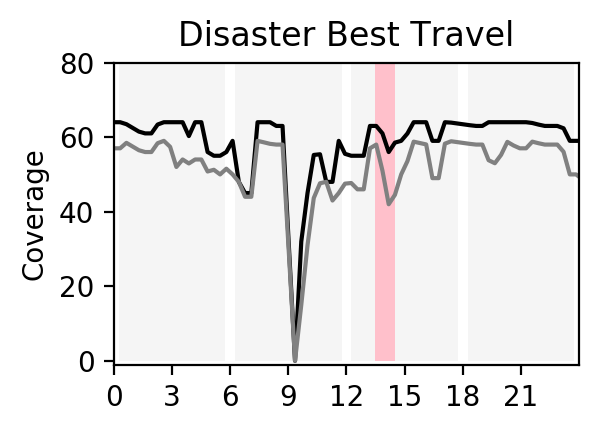

plotting  tj disaster best travel times
Show.


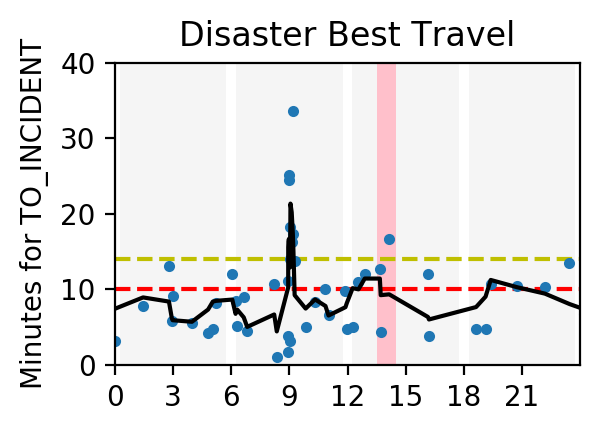

tj-disaster-best-coverage/metrics.csv ['grey', 'black']
Name is tj-disaster-best-coverage/metrics.csv
[[<matplotlib.lines.Line2D object at 0x119124050>], [<matplotlib.lines.Line2D object at 0x1193d0190>]]
[[<matplotlib.lines.Line2D object at 0x119124050>], [<matplotlib.lines.Line2D object at 0x1193d0190>]]
Note: the colors are [secondary color, primary color].


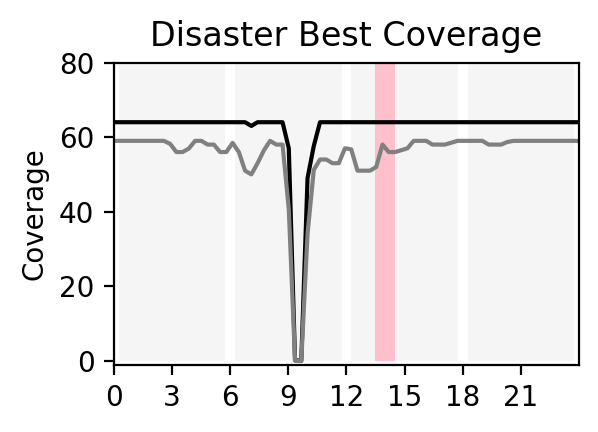

plotting  tj disaster best coverage times
Show.


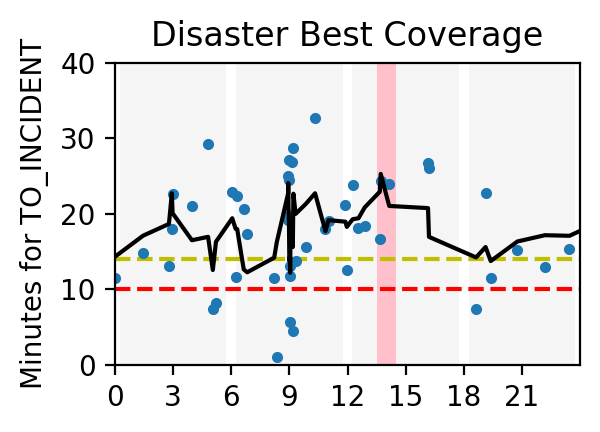

tj-disaster-weighted-dispatch/metrics.csv ['grey', 'black']
Name is tj-disaster-weighted-dispatch/metrics.csv
[[<matplotlib.lines.Line2D object at 0x118c69350>], [<matplotlib.lines.Line2D object at 0x118c69210>]]
[[<matplotlib.lines.Line2D object at 0x118c69350>], [<matplotlib.lines.Line2D object at 0x118c69210>]]
Note: the colors are [secondary color, primary color].


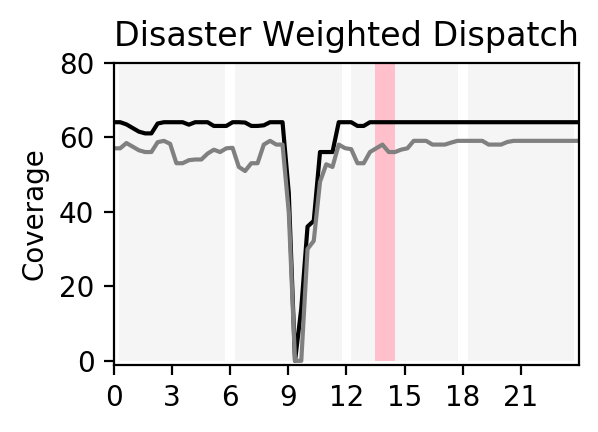

plotting  tj disaster weighted dispatch times
Show.


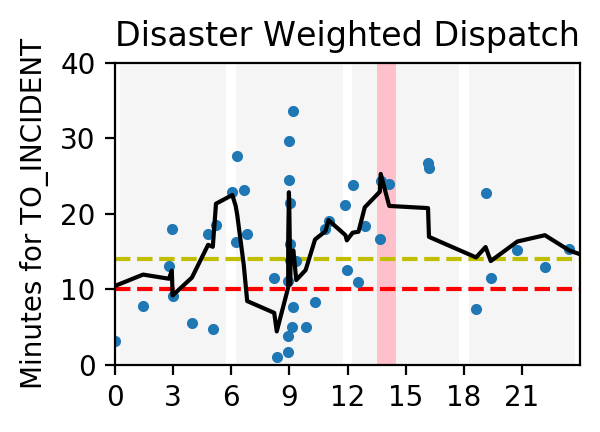

tj-weekend-best-travel/metrics.csv ['grey', 'black']
Name is tj-weekend-best-travel/metrics.csv
[[<matplotlib.lines.Line2D object at 0x11f0f8310>], [<matplotlib.lines.Line2D object at 0x11f1021d0>]]
[[<matplotlib.lines.Line2D object at 0x11f0f8310>], [<matplotlib.lines.Line2D object at 0x11f1021d0>]]
Note: the colors are [secondary color, primary color].


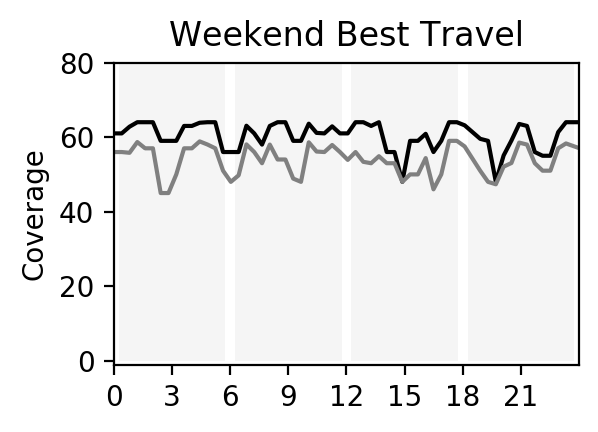

plotting  tj weekend best travel times
Show.


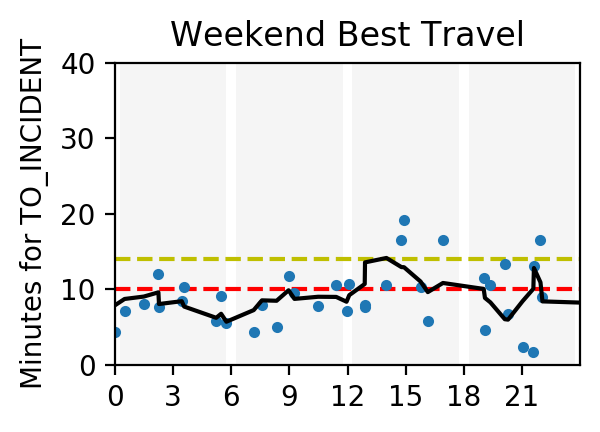

tj-weekend-best-coverage/metrics.csv ['grey', 'black']
Name is tj-weekend-best-coverage/metrics.csv
[[<matplotlib.lines.Line2D object at 0x11aad6c50>], [<matplotlib.lines.Line2D object at 0x11f042850>]]
[[<matplotlib.lines.Line2D object at 0x11aad6c50>], [<matplotlib.lines.Line2D object at 0x11f042850>]]
Note: the colors are [secondary color, primary color].


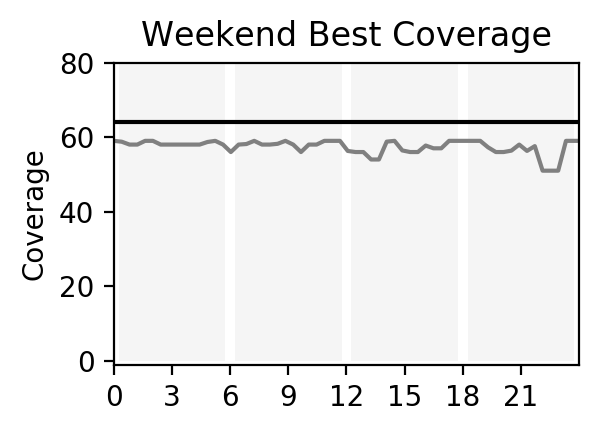

plotting  tj weekend best coverage times
Show.


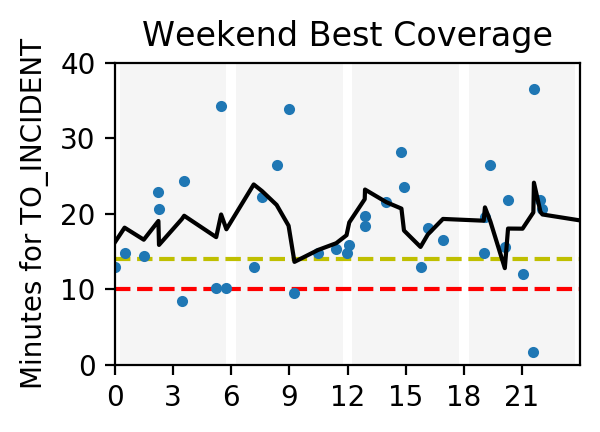

tj-weekend-weighted-dispatch/metrics.csv ['grey', 'black']
Name is tj-weekend-weighted-dispatch/metrics.csv
[[<matplotlib.lines.Line2D object at 0x118d4d910>], [<matplotlib.lines.Line2D object at 0x118d9b890>]]
[[<matplotlib.lines.Line2D object at 0x118d4d910>], [<matplotlib.lines.Line2D object at 0x118d9b890>]]
Note: the colors are [secondary color, primary color].


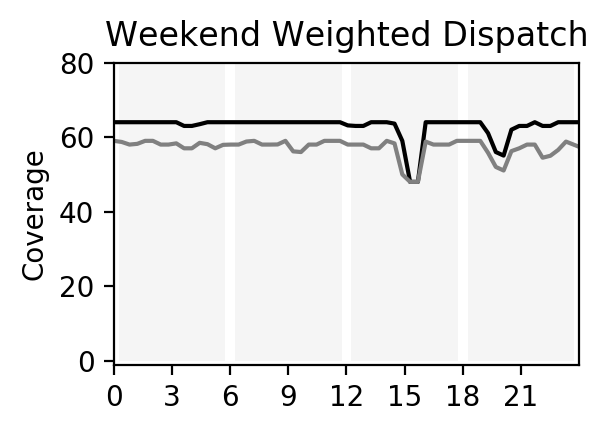

plotting  tj weekend weighted dispatch times
Show.


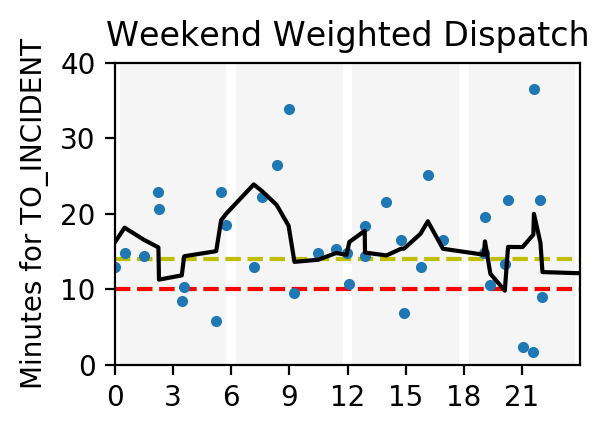

tj-weekday-best-travel/metrics.csv ['grey', 'black']
Name is tj-weekday-best-travel/metrics.csv
[[<matplotlib.lines.Line2D object at 0x119484b10>], [<matplotlib.lines.Line2D object at 0x119484450>]]
[[<matplotlib.lines.Line2D object at 0x119484b10>], [<matplotlib.lines.Line2D object at 0x119484450>]]
Note: the colors are [secondary color, primary color].


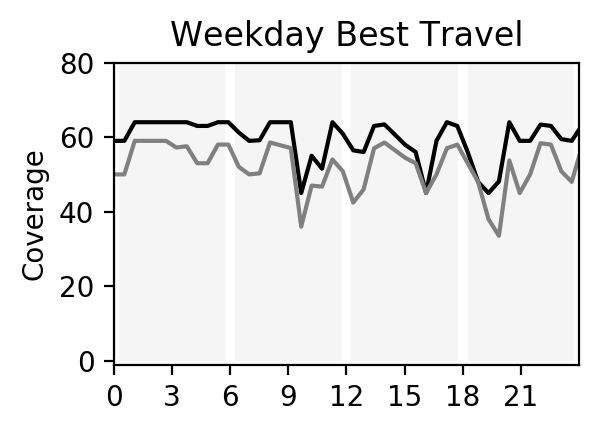

plotting  tj weekday best travel times
Show.


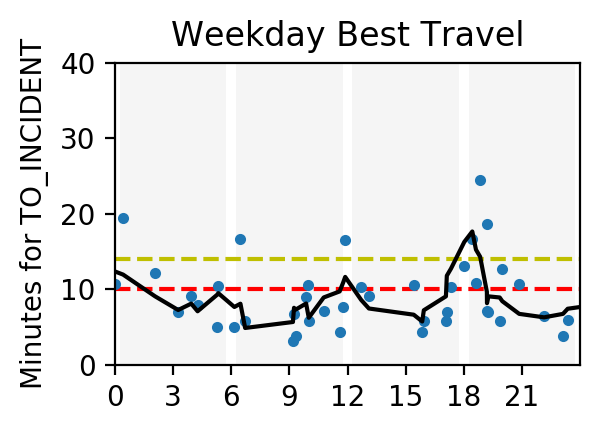

tj-weekday-best-coverage/metrics.csv ['grey', 'black']
Name is tj-weekday-best-coverage/metrics.csv
[[<matplotlib.lines.Line2D object at 0x11aa3e250>], [<matplotlib.lines.Line2D object at 0x11aa3e290>]]
[[<matplotlib.lines.Line2D object at 0x11aa3e250>], [<matplotlib.lines.Line2D object at 0x11aa3e290>]]
Note: the colors are [secondary color, primary color].


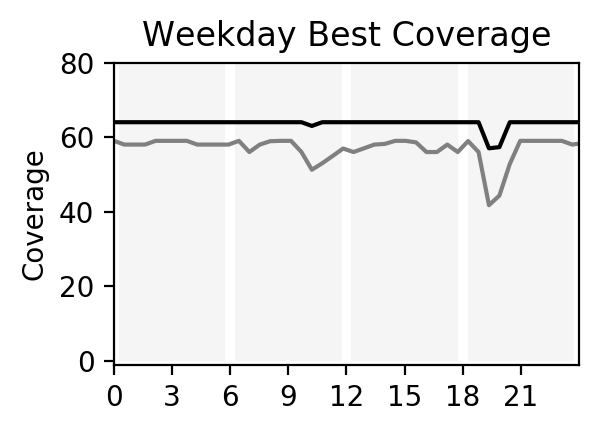

plotting  tj weekday best coverage times
Show.


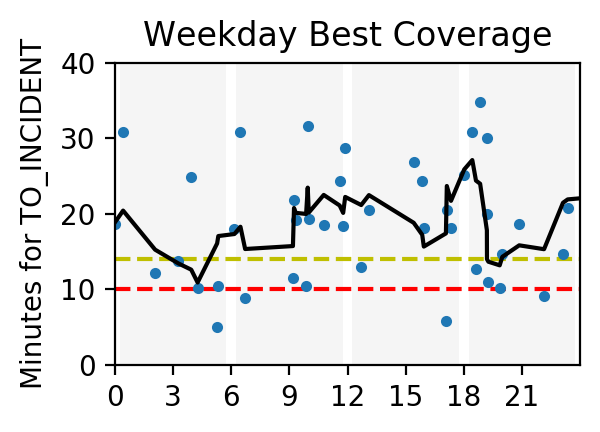

tj-weekday-weighted-dispatch/metrics.csv ['grey', 'black']
Name is tj-weekday-weighted-dispatch/metrics.csv
[[<matplotlib.lines.Line2D object at 0x11ab1ed50>], [<matplotlib.lines.Line2D object at 0x11ab001d0>]]
[[<matplotlib.lines.Line2D object at 0x11ab1ed50>], [<matplotlib.lines.Line2D object at 0x11ab001d0>]]
Note: the colors are [secondary color, primary color].


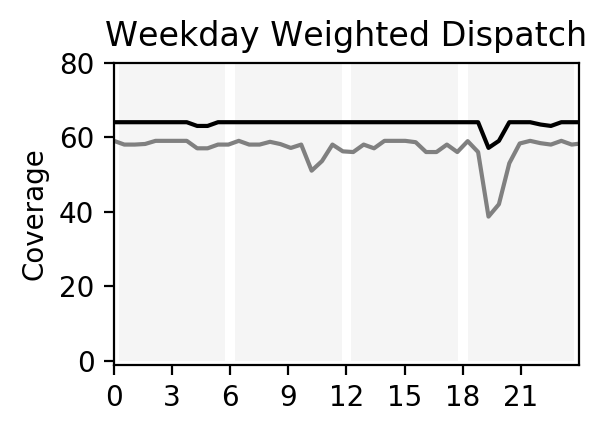

plotting  tj weekday weighted dispatch times
Show.


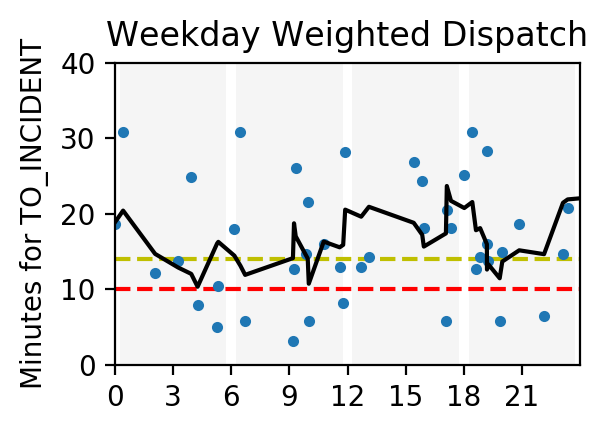

In [38]:
for s in simulation:
    plot_overlay_both(s, coverage_levels)

tj-disaster-best-travel/metrics.csv ['grey', 'black']
Name is tj-disaster-best-travel/metrics.csv
[[<matplotlib.lines.Line2D object at 0x1193bb750>], [<matplotlib.lines.Line2D object at 0x1193bb510>]]
[[<matplotlib.lines.Line2D object at 0x1193bb750>], [<matplotlib.lines.Line2D object at 0x1193bb510>]]
Note: the colors are [secondary color, primary color].


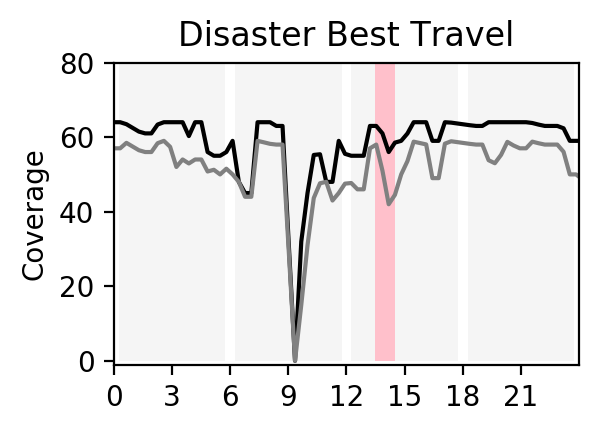

plotting  tj disaster best travel times
Show.


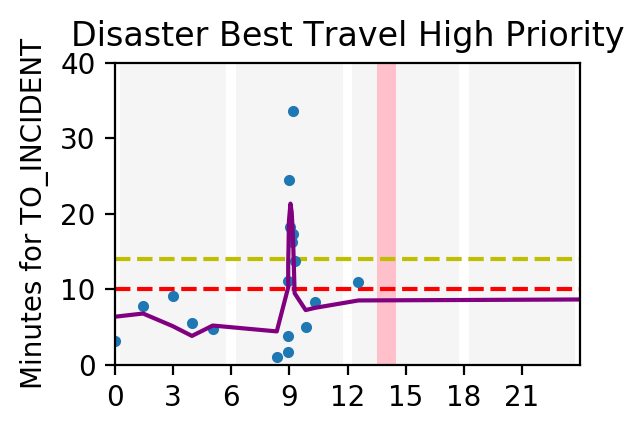

tj-disaster-best-coverage/metrics.csv ['grey', 'black']
Name is tj-disaster-best-coverage/metrics.csv
[[<matplotlib.lines.Line2D object at 0x118c3e990>], [<matplotlib.lines.Line2D object at 0x118c3e390>]]
[[<matplotlib.lines.Line2D object at 0x118c3e990>], [<matplotlib.lines.Line2D object at 0x118c3e390>]]
Note: the colors are [secondary color, primary color].


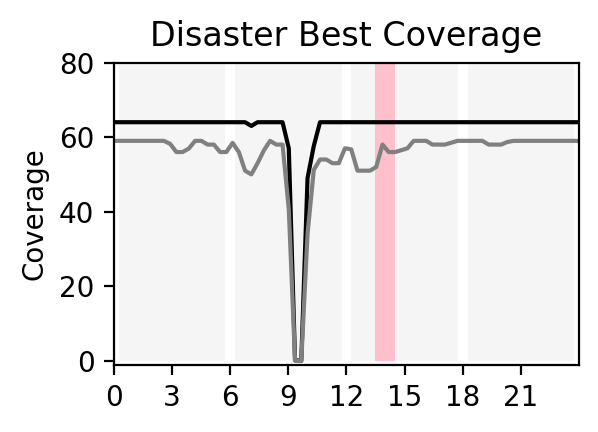

plotting  tj disaster best coverage times
Show.


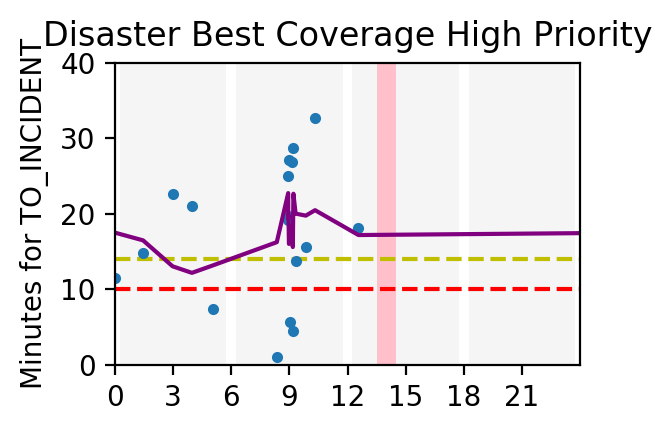

tj-disaster-weighted-dispatch/metrics.csv ['grey', 'black']
Name is tj-disaster-weighted-dispatch/metrics.csv
[[<matplotlib.lines.Line2D object at 0x11f2537d0>], [<matplotlib.lines.Line2D object at 0x11f253810>]]
[[<matplotlib.lines.Line2D object at 0x11f2537d0>], [<matplotlib.lines.Line2D object at 0x11f253810>]]
Note: the colors are [secondary color, primary color].


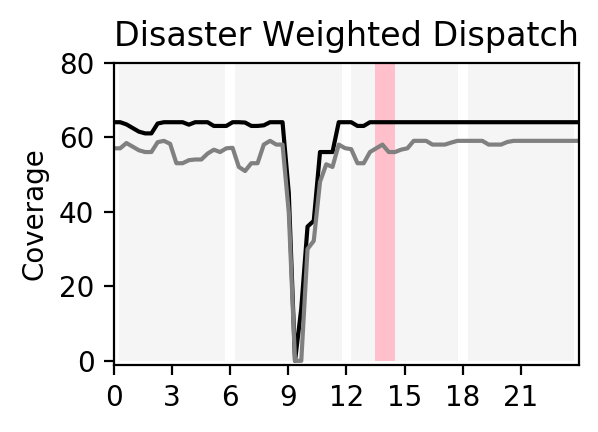

plotting  tj disaster weighted dispatch times
Show.


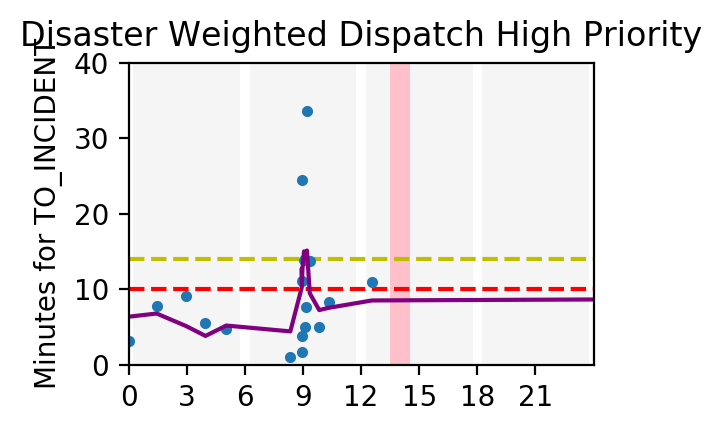

tj-weekend-best-travel/metrics.csv ['grey', 'black']
Name is tj-weekend-best-travel/metrics.csv
[[<matplotlib.lines.Line2D object at 0x118c696d0>], [<matplotlib.lines.Line2D object at 0x1072d5a50>]]
[[<matplotlib.lines.Line2D object at 0x118c696d0>], [<matplotlib.lines.Line2D object at 0x1072d5a50>]]
Note: the colors are [secondary color, primary color].


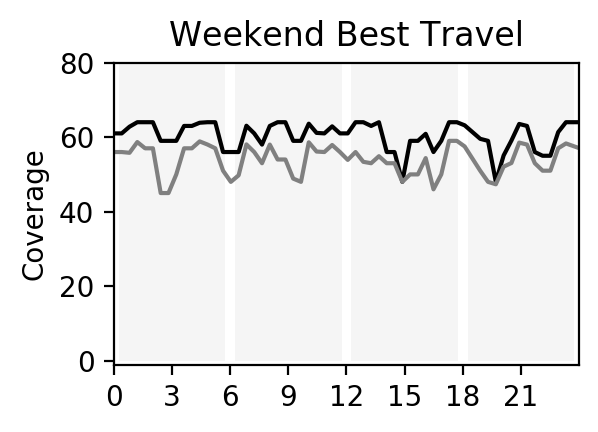

plotting  tj weekend best travel times
Show.


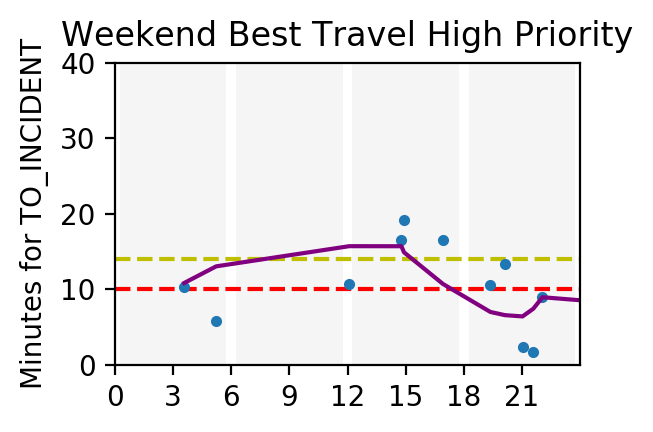

tj-weekend-best-coverage/metrics.csv ['grey', 'black']
Name is tj-weekend-best-coverage/metrics.csv
[[<matplotlib.lines.Line2D object at 0x119e90650>], [<matplotlib.lines.Line2D object at 0x119e90f10>]]
[[<matplotlib.lines.Line2D object at 0x119e90650>], [<matplotlib.lines.Line2D object at 0x119e90f10>]]
Note: the colors are [secondary color, primary color].


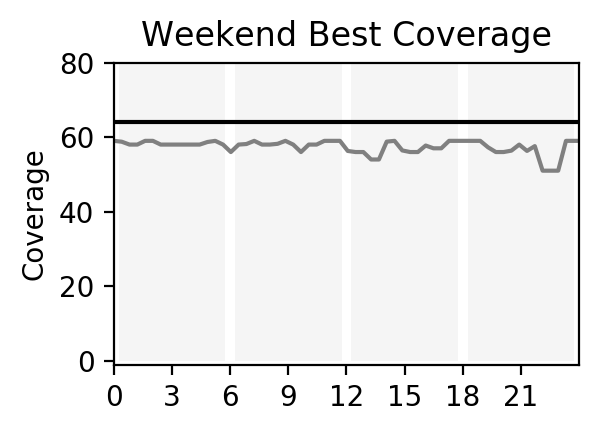

plotting  tj weekend best coverage times
Show.


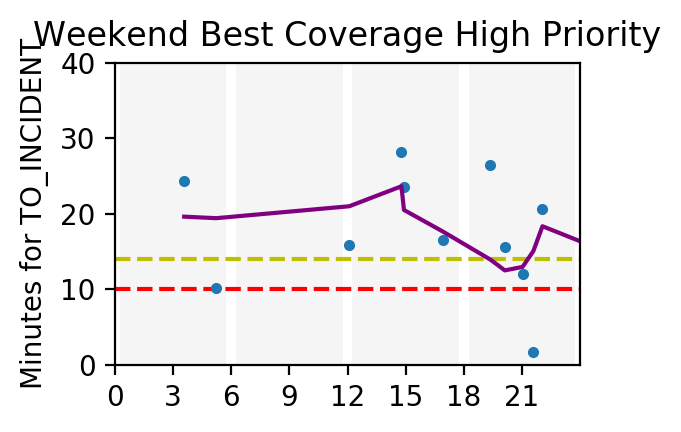

tj-weekend-weighted-dispatch/metrics.csv ['grey', 'black']
Name is tj-weekend-weighted-dispatch/metrics.csv
[[<matplotlib.lines.Line2D object at 0x1193476d0>], [<matplotlib.lines.Line2D object at 0x11934c590>]]
[[<matplotlib.lines.Line2D object at 0x1193476d0>], [<matplotlib.lines.Line2D object at 0x11934c590>]]
Note: the colors are [secondary color, primary color].


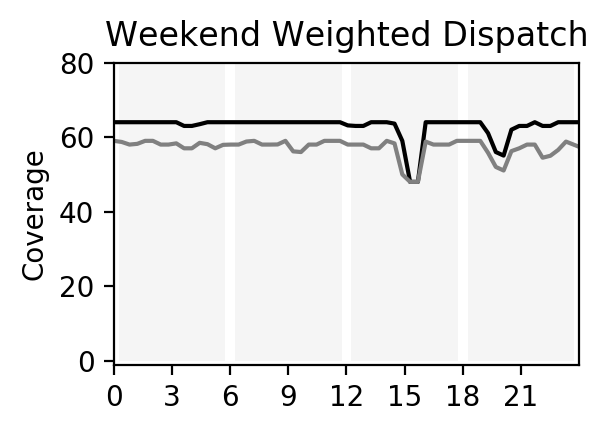

plotting  tj weekend weighted dispatch times
Show.


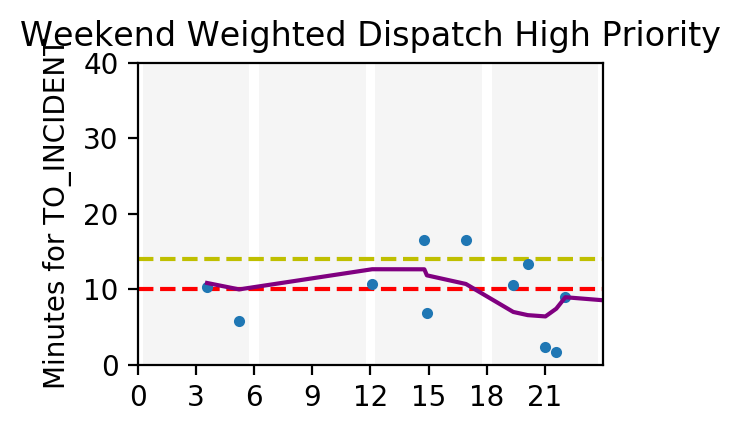

tj-weekday-best-travel/metrics.csv ['grey', 'black']
Name is tj-weekday-best-travel/metrics.csv
[[<matplotlib.lines.Line2D object at 0x11a642850>], [<matplotlib.lines.Line2D object at 0x11a642c10>]]
[[<matplotlib.lines.Line2D object at 0x11a642850>], [<matplotlib.lines.Line2D object at 0x11a642c10>]]
Note: the colors are [secondary color, primary color].


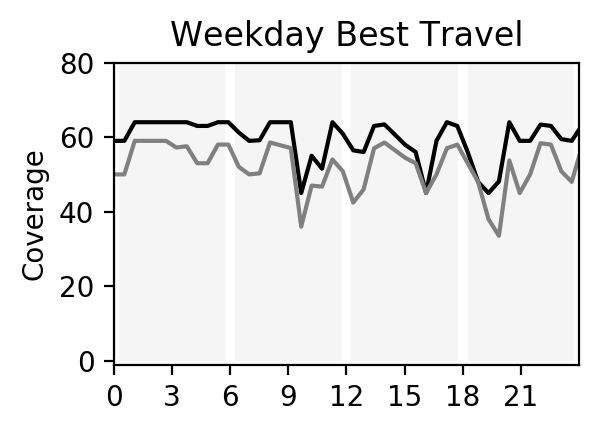

plotting  tj weekday best travel times
Show.


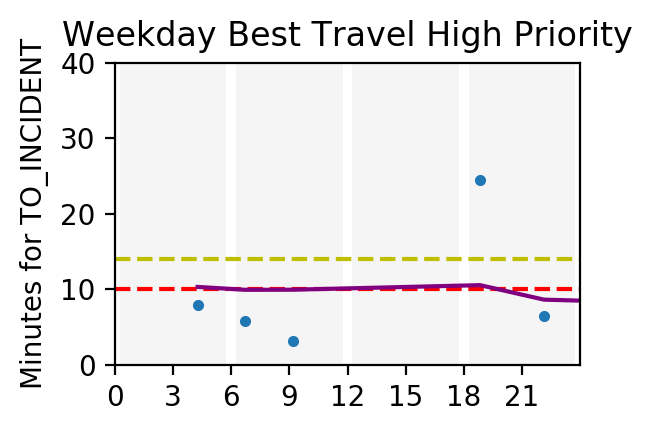

tj-weekday-best-coverage/metrics.csv ['grey', 'black']
Name is tj-weekday-best-coverage/metrics.csv
[[<matplotlib.lines.Line2D object at 0x119402a50>], [<matplotlib.lines.Line2D object at 0x119402d90>]]
[[<matplotlib.lines.Line2D object at 0x119402a50>], [<matplotlib.lines.Line2D object at 0x119402d90>]]
Note: the colors are [secondary color, primary color].


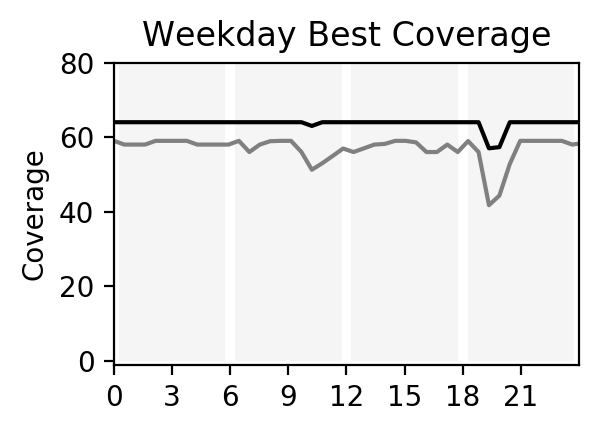

plotting  tj weekday best coverage times
Show.


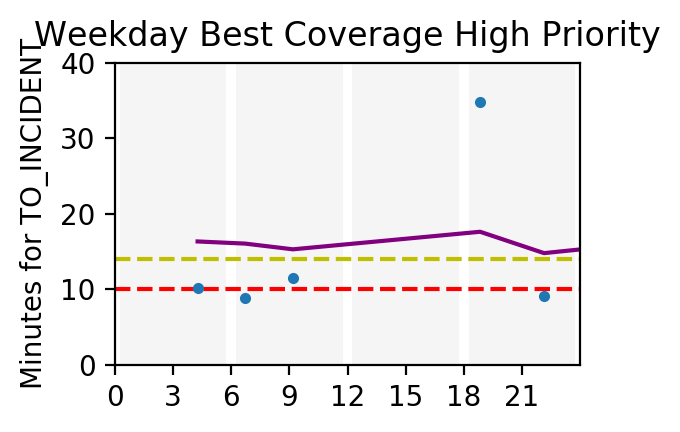

tj-weekday-weighted-dispatch/metrics.csv ['grey', 'black']
Name is tj-weekday-weighted-dispatch/metrics.csv
[[<matplotlib.lines.Line2D object at 0x11961e850>], [<matplotlib.lines.Line2D object at 0x118cc2990>]]
[[<matplotlib.lines.Line2D object at 0x11961e850>], [<matplotlib.lines.Line2D object at 0x118cc2990>]]
Note: the colors are [secondary color, primary color].


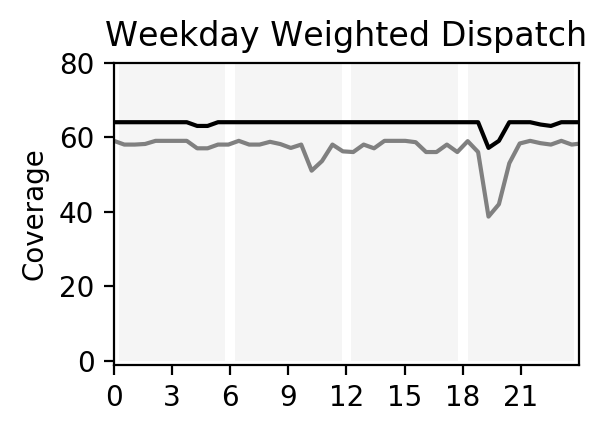

plotting  tj weekday weighted dispatch times
Show.


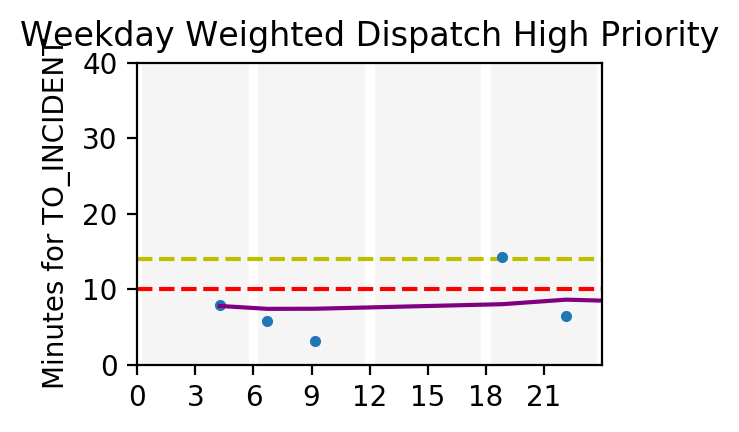

In [39]:
for s in simulation:
    plot_overlay_both(s, coverage_levels, highpriority=True)

# Scaling the Disaster Lambda Rates

#### We want to see the effect of scaling the lambda on the coverage. 

#### DEBUG THE DISASTER SCENARIO HERE


/depleting-until-zero/metrics.csv ['grey', 'black']
Name is /depleting-until-zero/metrics.csv
[[<matplotlib.lines.Line2D object at 0x11aa691d0>], [<matplotlib.lines.Line2D object at 0x11aa69210>]]
[[<matplotlib.lines.Line2D object at 0x11aa691d0>], [<matplotlib.lines.Line2D object at 0x11aa69210>]]
Note: the colors are [secondary color, primary color].


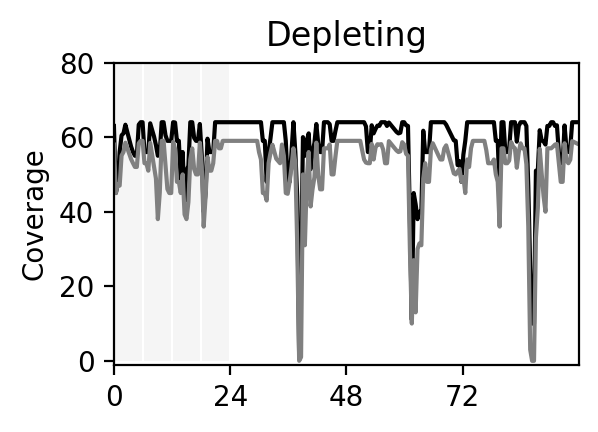

plotting   times
Show.


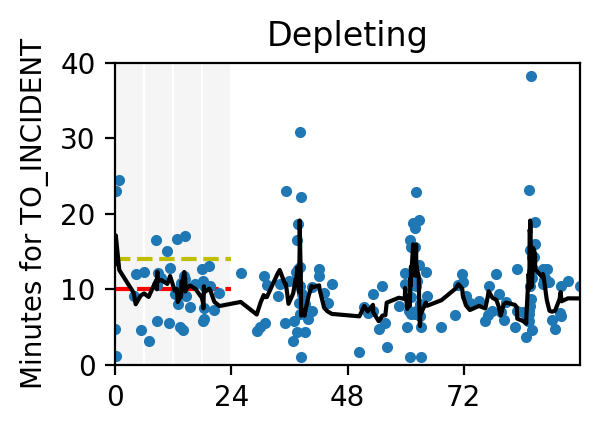

In [40]:
plot_overlay_both('depleting', coverage_levels, xlim_cap=96, ticks=4)

# NORMAL WEEKDAYS AND WEEKENDS SCENARIOS, XLIM 1 WEEK

/scaling-weeks-best-travel/metrics.csv ['grey', 'black']
Name is /scaling-weeks-best-travel/metrics.csv
[[<matplotlib.lines.Line2D object at 0x119b3e710>], [<matplotlib.lines.Line2D object at 0x119b3e7d0>]]
[[<matplotlib.lines.Line2D object at 0x119b3e710>], [<matplotlib.lines.Line2D object at 0x119b3e7d0>]]
Note: the colors are [secondary color, primary color].


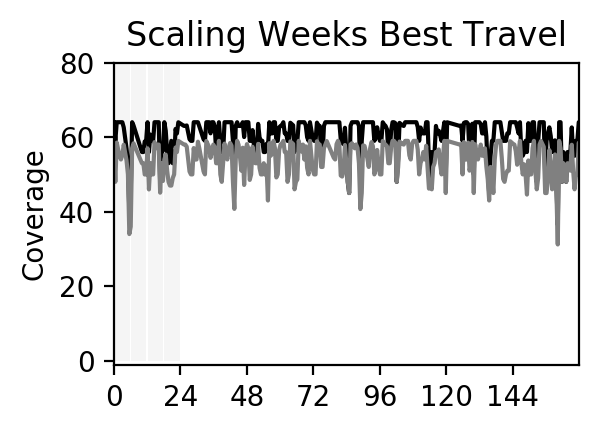

plotting   times
Show.


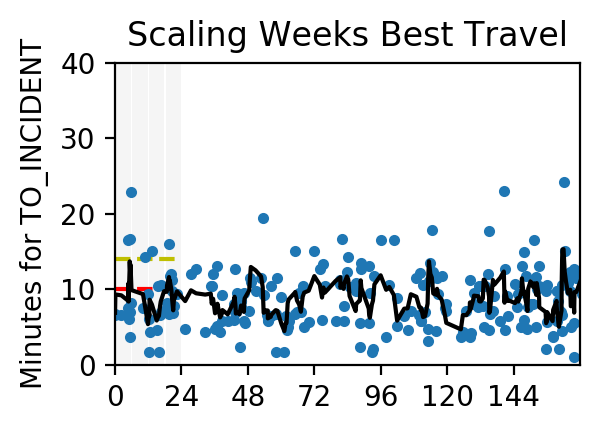

In [41]:
plot_overlay_both('scaling-weeks-best-travel', coverage_levels, xlim_cap=168, ticks=7)

/scaling-weeks-best-coverage/metrics.csv ['grey', 'black']
Name is /scaling-weeks-best-coverage/metrics.csv
[[<matplotlib.lines.Line2D object at 0x1194b4c50>], [<matplotlib.lines.Line2D object at 0x1193bbf90>]]
[[<matplotlib.lines.Line2D object at 0x1194b4c50>], [<matplotlib.lines.Line2D object at 0x1193bbf90>]]
Note: the colors are [secondary color, primary color].


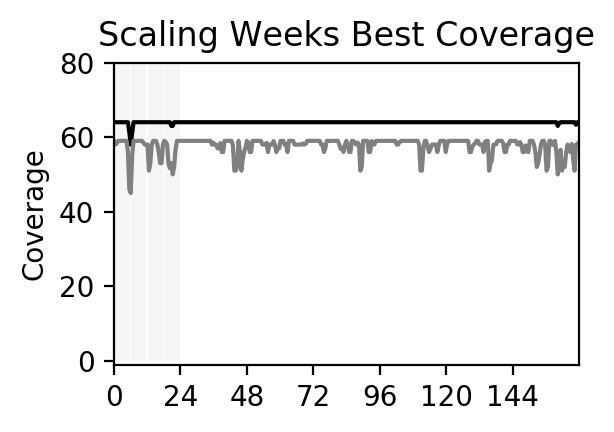

plotting   times
Show.


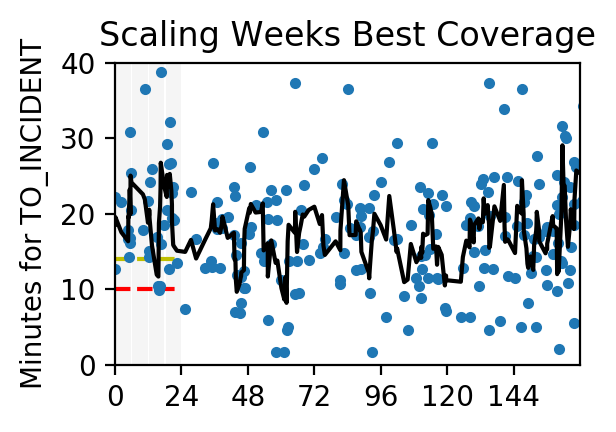

In [42]:
plot_overlay_both('scaling-weeks-best-coverage', coverage_levels, xlim_cap=168, ticks=7)

In [43]:
print("Done")

Done
